In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from scipy import stats
import warnings
warnings.filterwarnings('ignore')
# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [2]:
# Load dataset
df = pd.read_csv("continuous dataset.csv", parse_dates=["datetime"])
df = df.set_index("datetime").sort_index()

In [3]:
df.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [4]:
print(len(df))

48048


In [5]:
print("Dataset shape:", df.shape)
print("Date range:", df.index.min(), "to", df.index.max())

Dataset shape: (48048, 16)
Date range: 2015-01-03 01:00:00 to 2020-06-27 00:00:00


In [6]:
# Split data (same as your SARIMA example)
split_time = "2019-10-13 01:00"
train = df.loc[df.index < split_time, 'nat_demand']
test = df.loc[df.index >= split_time, 'nat_demand']

print(f"\nTrain shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Train period: {train.index.min()} to {train.index.max()}")
print(f"Test period: {test.index.min()} to {test.index.max()}")
test.tail()


Train shape: (41856,)
Test shape: (6192,)
Train period: 2015-01-03 01:00:00 to 2019-10-13 00:00:00
Test period: 2019-10-13 01:00:00 to 2020-06-27 00:00:00


,nat_demand
datetime,
2020-06-26 20:00:00,1128.5592
2020-06-26 21:00:00,1112.7488
2020-06-26 22:00:00,1081.5680
2020-06-26 23:00:00,1041.6240
2020-06-27 00:00:00,1013.5683


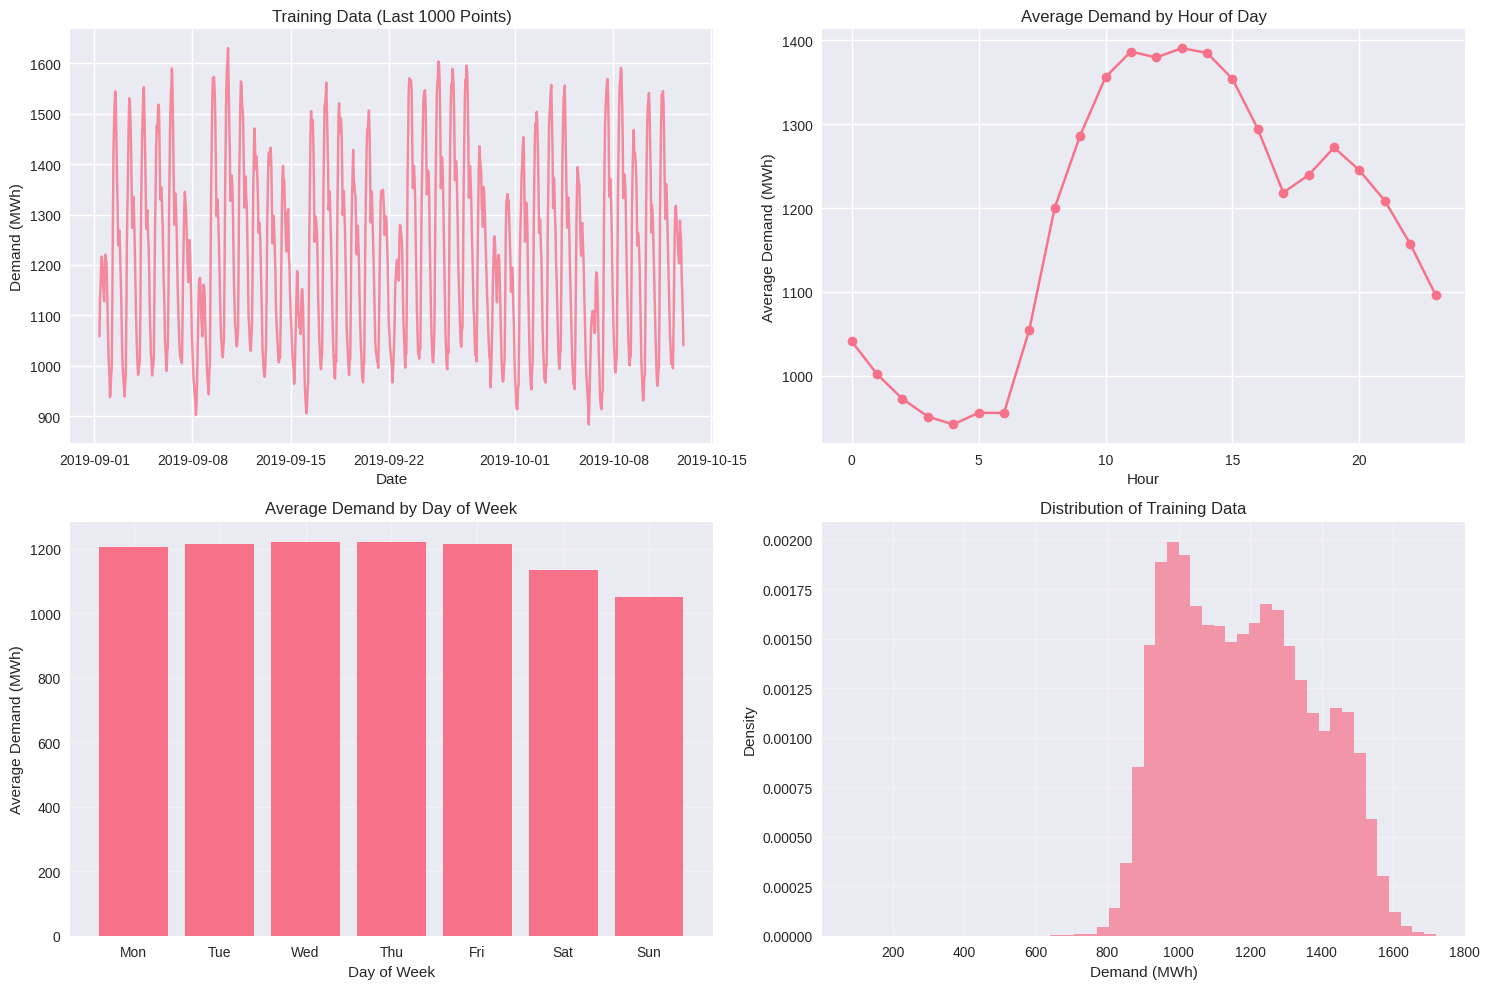

In [7]:
# Data exploration for exponential smoothing
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Time series plot
axes[0,0].plot(train[-1000:], alpha=0.8)
axes[0,0].set_title('Training Data (Last 1000 Points)')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Demand (MWh)')
axes[0,0].grid(True)

# Seasonal pattern (daily)
daily_pattern = train.groupby(train.index.hour).mean()
axes[0,1].plot(daily_pattern.index, daily_pattern.values, marker='o')
axes[0,1].set_title('Average Demand by Hour of Day')
axes[0,1].set_xlabel('Hour')
axes[0,1].set_ylabel('Average Demand (MWh)')
axes[0,1].grid(True)

# Weekly pattern
weekly_pattern = train.groupby(train.index.dayofweek).mean()
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1,0].bar(range(7), weekly_pattern.values)
axes[1,0].set_title('Average Demand by Day of Week')
axes[1,0].set_xlabel('Day of Week')
axes[1,0].set_ylabel('Average Demand (MWh)')
axes[1,0].set_xticks(range(7))
axes[1,0].set_xticklabels(day_names)
axes[1,0].grid(True, alpha=0.3)

# Distribution
axes[1,1].hist(train, bins=50, alpha=0.7, density=True)
axes[1,1].set_title('Distribution of Training Data')
axes[1,1].set_xlabel('Demand (MWh)')
axes[1,1].set_ylabel('Density')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Test different Exponential Smoothing models
print("\n" + "="*60)
print("EXPONENTIAL SMOOTHING MODEL COMPARISON")
print("="*60)

models_to_test = [
      ('Simple', None, None, None),
    ('Double', 'add', None, None),
    ('Triple_Add', 'add', 'add', 24),
     ('Triple_Mul', 'mul', 'mul', 24),
     ('Triple_Add_Damped', 'add', 'add', 24),
     ('Triple_Mul_Damped', 'mul', 'mul', 24)
]

model_results = {}
best_model = None
best_aic = float('inf')

for name, trend, seasonal, seasonal_periods in models_to_test:
    try:
        print(f"\nTesting {name} Exponential Smoothing...")

        # Handle damped models
        damped_trend = 'damped' in name.lower()
        if damped_trend:
            trend = trend if trend else 'add'

        # Create model
        if name == 'Simple':
            model = ExponentialSmoothing(train, trend=None, seasonal=None)
        else:
            model = ExponentialSmoothing(
                train,
                trend=trend,
                seasonal=seasonal,
                seasonal_periods=seasonal_periods,
                damped_trend=damped_trend
            )

        # Fit model
        fitted_model = model.fit(optimized=True, use_brute=True)

        # Make forecast
        forecast = fitted_model.forecast(len(test))

        # Calculate metrics
        mse = mean_squared_error(test, forecast)
        mae = mean_absolute_error(test, forecast)
        mape = mean_absolute_percentage_error(test, forecast) * 100
        aic = fitted_model.aic if hasattr(fitted_model, 'aic') else float('inf')

        model_results[name] = {
            'model': fitted_model,
            'forecast': forecast,
            'mse': mse,
            'mae': mae,
            'mape': mape,
            'aic': aic,
            'params': fitted_model.params
        }

        print(f"  AIC: {aic:.2f}")
        print(f"  MAPE: {mape:.2f}%")
        print(f"  MAE: {mae:.2f}")

        # Track best model
        if mape < 15 and aic < best_aic:  # Only consider models with reasonable MAPE
            best_aic = aic
            best_model = name

    except Exception as e:
        print(f"  Failed: {str(e)}")
        continue



EXPONENTIAL SMOOTHING MODEL COMPARISON

Testing Simple Exponential Smoothing...
  AIC: 343990.96
  MAPE: 13.76%
  MAE: 180.98

Testing Double Exponential Smoothing...
  AIC: 327001.68
  MAPE: 15141.32%
  MAE: 172116.09

Testing Triple_Add Exponential Smoothing...
  AIC: 277981.02
  MAPE: 10.56%
  MAE: 125.56

Testing Triple_Mul Exponential Smoothing...
  AIC: 272265.85
  MAPE: 34.38%
  MAE: 408.23

Testing Triple_Add_Damped Exponential Smoothing...
  AIC: 277708.98
  MAPE: 9.99%
  MAE: 120.81

Testing Triple_Mul_Damped Exponential Smoothing...
  AIC: 272266.18
  MAPE: 10.01%
  MAE: 119.49


In [9]:
# Select best model
if best_model:
    print(f"\n{'='*60}")
    print(f"BEST MODEL: {best_model} (AIC: {best_aic:.2f})")
    print(f"{'='*60}")

    best_fit = model_results[best_model]
    best_forecast = best_fit['forecast']

    # Print model parameters
    print(f"\nModel Parameters:")
    for param, value in best_fit['params'].items():
        if isinstance(value, np.ndarray):
            # Print first few elements of the array
            print(f"  {param}: {value[:5]}... (shape {value.shape})")
        elif isinstance(value, (int, float, np.floating)):
             print(f"  {param}: {value:.4f}")
        else:
            print(f"  {param}: {value}")


else:
    # Fallback to the model with best MAPE
    best_model = min(model_results.keys(), key=lambda x: model_results[x]['mape'])
    best_fit = model_results[best_model]
    best_forecast = best_fit['forecast']
    print(f"\nUsing model with best MAPE: {best_model}")


BEST MODEL: Triple_Mul_Damped (AIC: 272266.18)

Model Parameters:
  smoothing_level: 1.0000
  smoothing_trend: 0.0000
  smoothing_seasonal: 0.0000
  damping_trend: 0.9763
  initial_level: 1071.1458
  initial_trend: 1.0220
  initial_seasons: [0.90845934 0.8819356  0.86297918 0.85456658 0.86728209]... (shape (24,))
  use_boxcox: 0.0000
  lamda: None
  remove_bias: 0.0000


In [10]:

# Ensure test data aligns with forecast by removing duplicate indices
test_aligned = test[~test.index.duplicated(keep='first')]

# Make sure forecast matches test data length
if len(best_forecast) > len(test_aligned):
    best_forecast = best_forecast[:len(test_aligned)]
elif len(best_forecast) < len(test_aligned):
    test_aligned = test_aligned[:len(best_forecast)]

# Comprehensive Performance Analysis
print(f"\n{'='*60}")
print(f"DETAILED PERFORMANCE ANALYSIS - {best_model}")
print(f"{'='*60}")

# Calculate residuals
residuals = test_aligned - best_forecast
rmse = np.sqrt(best_fit['mse'])
correlation = np.corrcoef(test_aligned, best_forecast)[0,1]
r_squared = correlation**2

print(f"MSE:  {best_fit['mse']:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {best_fit['mae']:.2f}")
print(f"MAPE: {best_fit['mape']:.2f}%")
print(f"R²:   {r_squared:.4f}")
print(f"Correlation: {correlation:.4f}")


DETAILED PERFORMANCE ANALYSIS - Triple_Mul_Damped
MSE:  22069.58
RMSE: 148.56
MAE:  119.49
MAPE: 10.01%
R²:   0.4078
Correlation: 0.6386


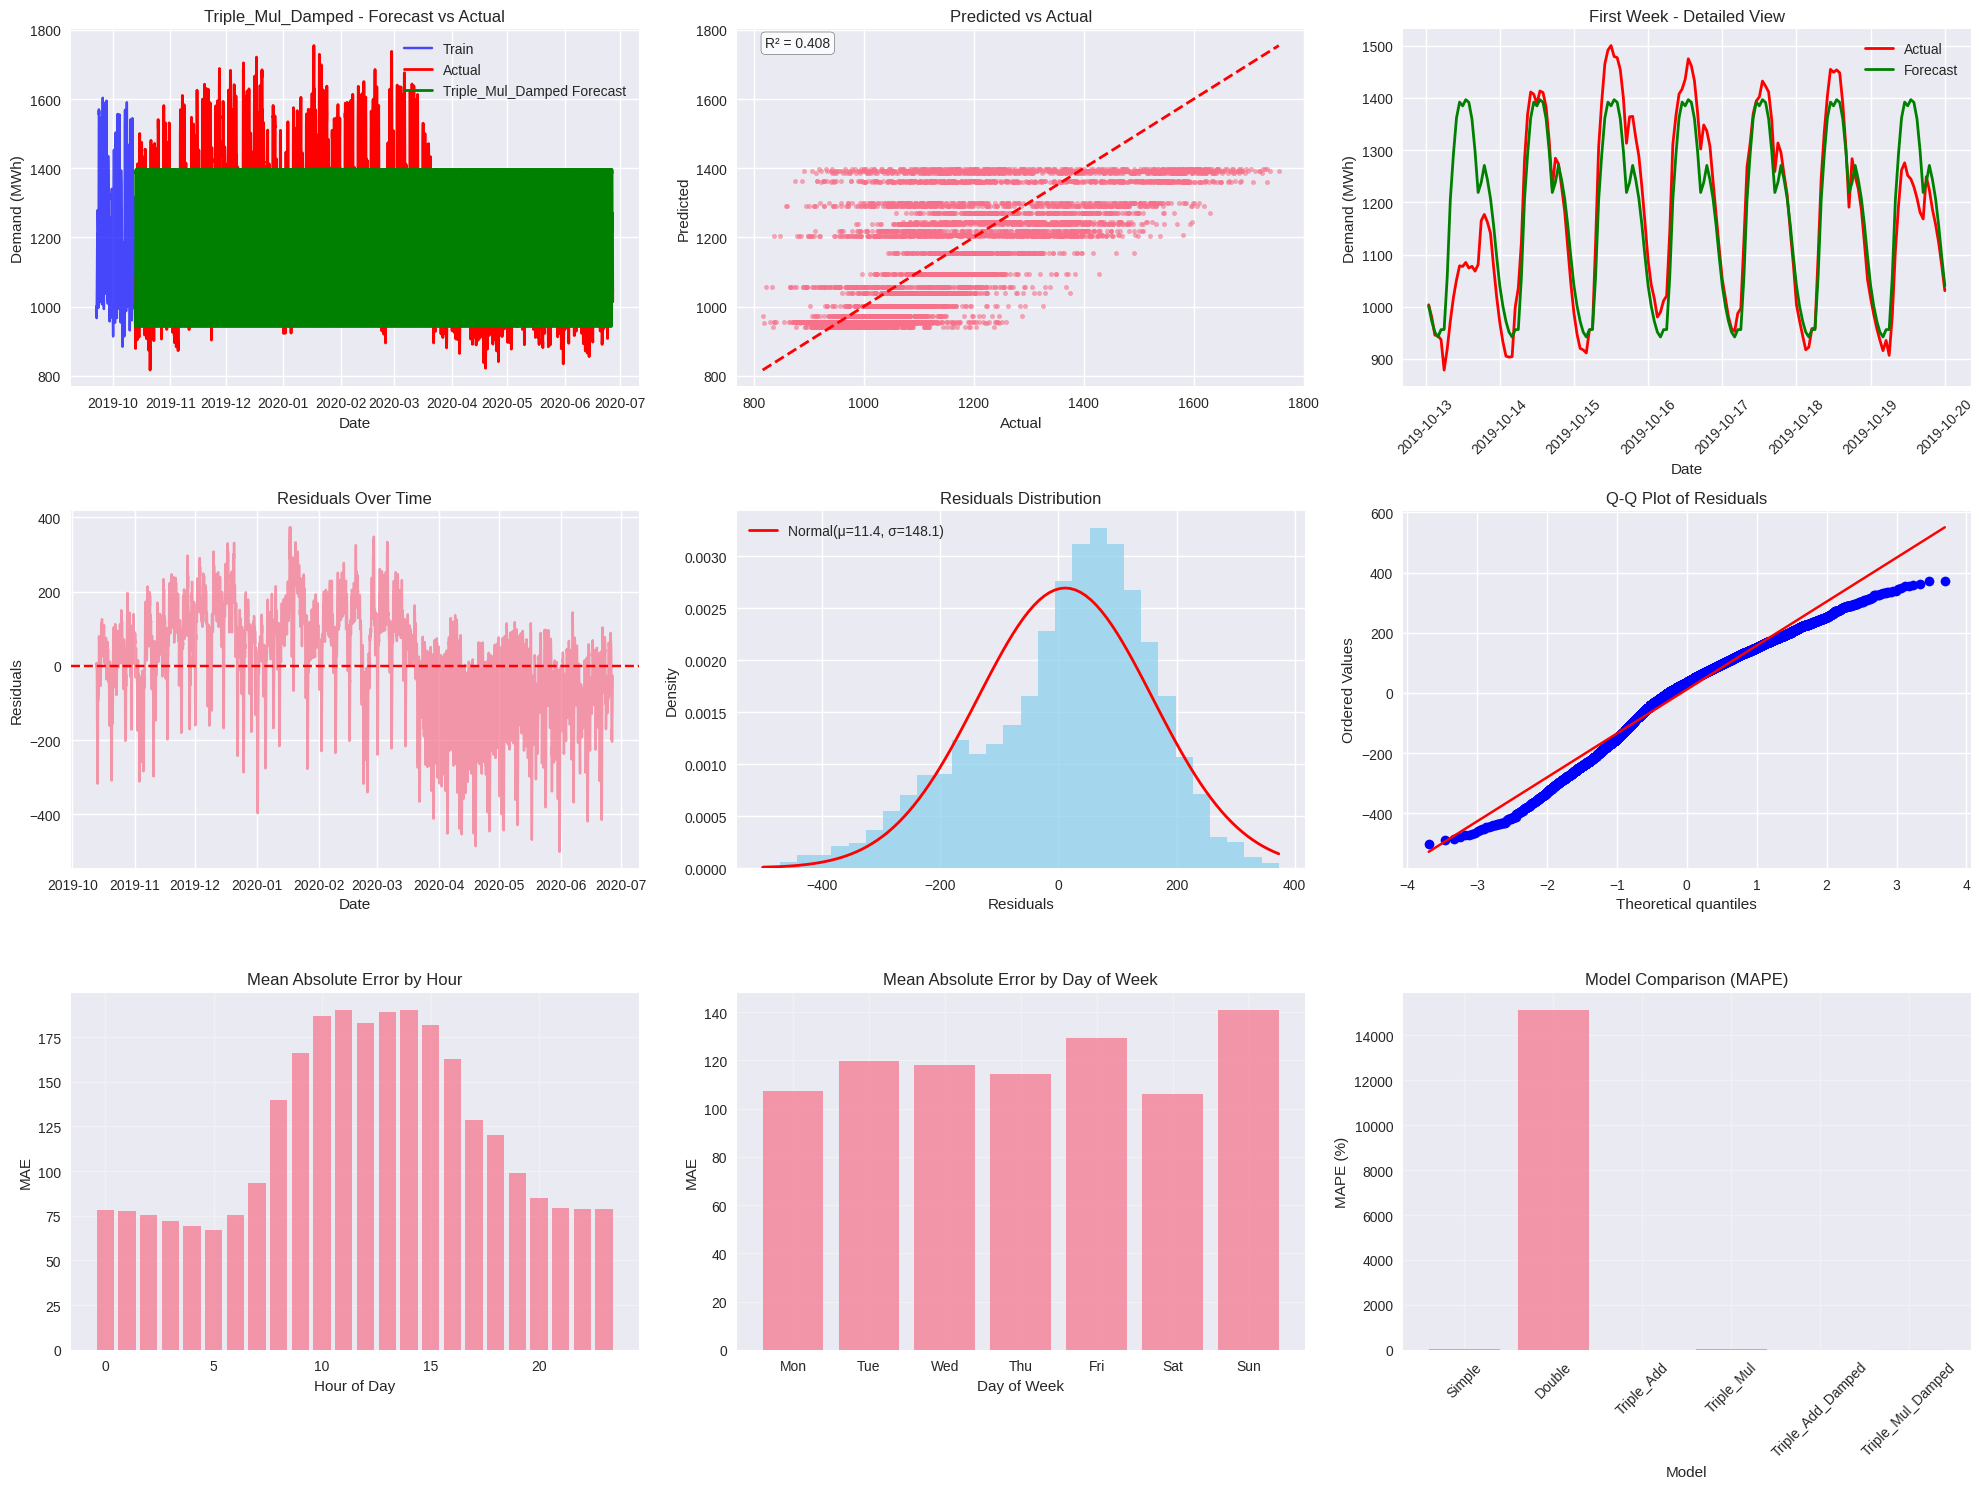

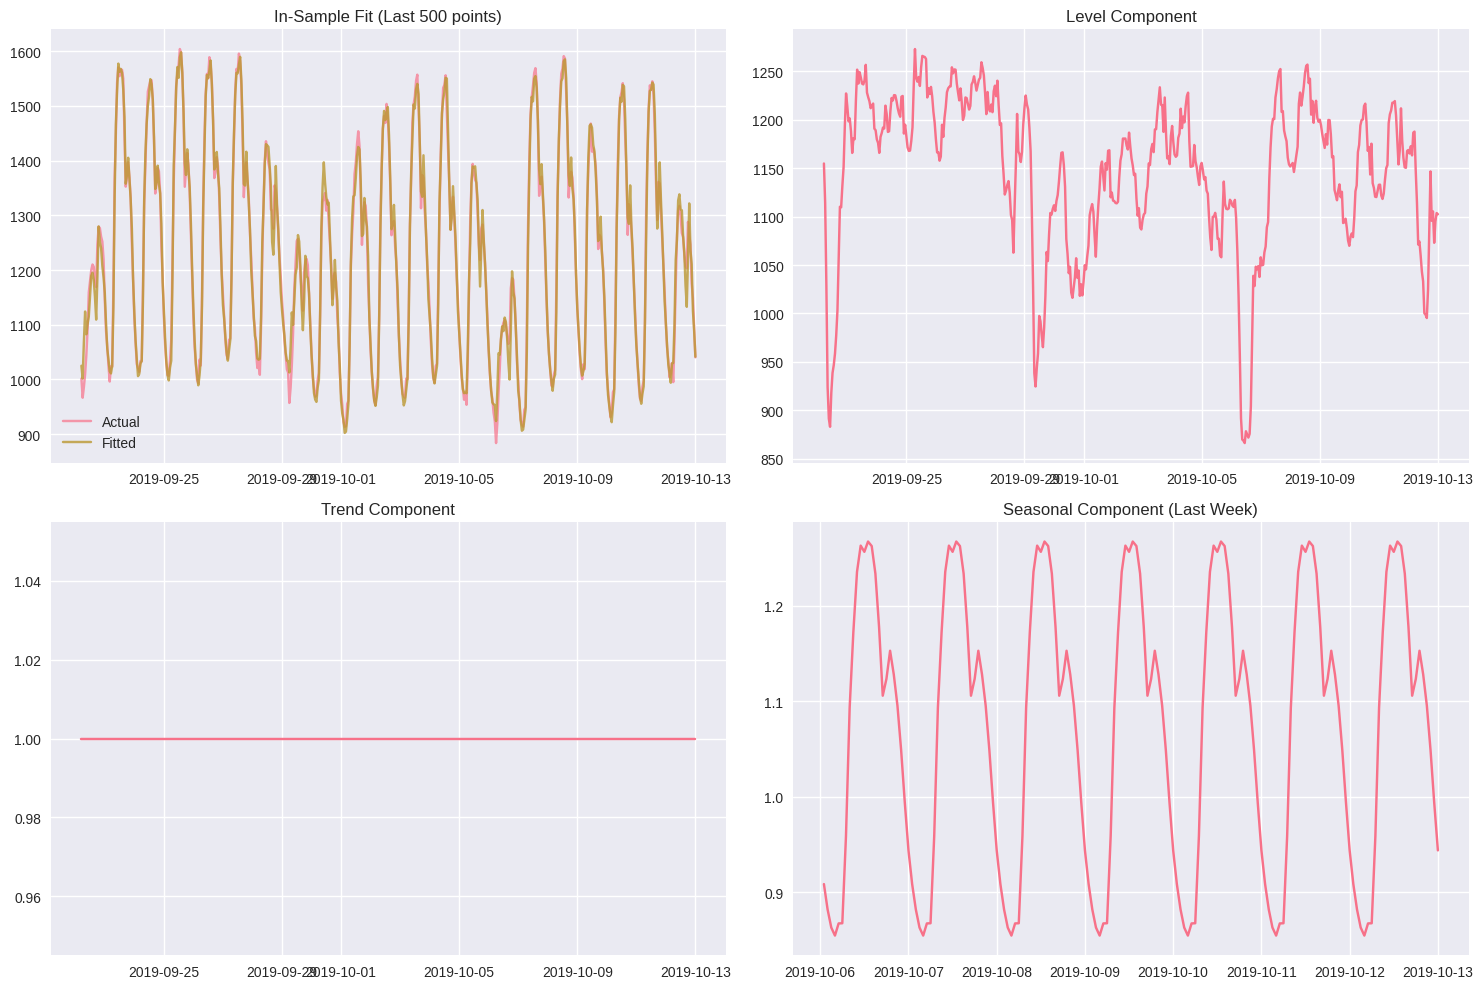

In [11]:
# Comprehensive visualization
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# Create test_df for error analysis
test_df = pd.DataFrame({
    'actual': test_aligned, # Use test_aligned for consistency with forecast alignment
    'forecast': best_forecast,
    'error': residuals,
    'abs_error': np.abs(residuals),
    'pct_error': (residuals / test_aligned) * 100 # Use test_aligned here too
})

test_df['hour'] = test_df.index.hour
test_df['day_of_week'] = test_df.index.day_of_week


# 1. Forecast vs Actual (overview)
axes[0,0].plot(train[-500:], label="Train", alpha=0.7, color='blue')
axes[0,0].plot(test, label="Actual", color='red', linewidth=2)
axes[0,0].plot(test.index, best_forecast, label=f"{best_model} Forecast", color='green', linewidth=2)
axes[0,0].set_title(f"{best_model} - Forecast vs Actual")
axes[0,0].set_xlabel("Date")
axes[0,0].set_ylabel("Demand (MWh)")
axes[0,0].legend()
axes[0,0].grid(True)

# 2. Predicted vs Actual scatter plot
axes[0,1].scatter(test, best_forecast, alpha=0.6, s=10)
axes[0,1].plot([test.min(), test.max()], [test.min(), test.max()], 'r--', lw=2)
axes[0,1].set_xlabel('Actual')
axes[0,1].set_ylabel('Predicted')
axes[0,1].set_title('Predicted vs Actual')
axes[0,1].grid(True)
axes[0,1].text(0.05, 0.95, f'R² = {r_squared:.3f}', transform=axes[0,1].transAxes,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. First week detailed view
first_week_test = test.iloc[:7*24]
first_week_forecast = best_forecast.iloc[:7*24]
axes[0,2].plot(first_week_test, label='Actual', linewidth=2, color='red')
axes[0,2].plot(first_week_test.index, first_week_forecast, label='Forecast', linewidth=2, color='green')
axes[0,2].set_title('First Week - Detailed View')
axes[0,2].set_xlabel('Date')
axes[0,2].set_ylabel('Demand (MWh)')
axes[0,2].legend()
axes[0,2].grid(True)
axes[0,2].tick_params(axis='x', rotation=45)

# 4. Residuals over time
axes[1,0].plot(test.index, residuals, alpha=0.7)
axes[1,0].axhline(y=0, color='r', linestyle='--')
axes[1,0].set_title('Residuals Over Time')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Residuals')
axes[1,0].grid(True)

# 5. Residuals distribution
axes[1,1].hist(residuals, bins=30, alpha=0.7, density=True, color='skyblue')
axes[1,1].set_title('Residuals Distribution')
axes[1,1].set_xlabel('Residuals')
axes[1,1].set_ylabel('Density')

# Overlay normal distribution
mu, sigma = stats.norm.fit(residuals)
x = np.linspace(residuals.min(), residuals.max(), 100)
axes[1,1].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label=f'Normal(μ={mu:.1f}, σ={sigma:.1f})')
axes[1,1].legend()
axes[1,1].grid(True)

# 6. Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1,2])
axes[1,2].set_title('Q-Q Plot of Residuals')
axes[1,2].grid(True)

# 7. Error by hour of day
hourly_error = test_df.groupby('hour')['abs_error'].mean()
axes[2,0].bar(hourly_error.index, hourly_error.values, alpha=0.7)
axes[2,0].set_title('Mean Absolute Error by Hour')
axes[2,0].set_xlabel('Hour of Day')
axes[2,0].set_ylabel('MAE')
axes[2,0].grid(True, alpha=0.3)

# 8. Error by day of week
daily_error = test_df.groupby('day_of_week')['abs_error'].mean()
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[2,1].bar(range(7), daily_error.values, alpha=0.7)
axes[2,1].set_title('Mean Absolute Error by Day of Week')
axes[2,1].set_xlabel('Day of Week')
axes[2,1].set_ylabel('MAE')
axes[2,1].set_xticks(range(7))
axes[2,1].set_xticklabels(day_names)
axes[2,1].grid(True, alpha=0.3)

# 9. Model comparison
if len(model_results) > 1:
    model_names = list(model_results.keys())
    mapes = [model_results[name]['mape'] for name in model_names]

    bars = axes[2,2].bar(range(len(model_names)), mapes, alpha=0.7)
    axes[2,2].set_title('Model Comparison (MAPE)')
    axes[2,2].set_xlabel('Model')
    axes[2,2].set_ylabel('MAPE (%)')
    axes[2,2].set_xticks(range(len(model_names)))
    axes[2,2].set_xticklabels(model_names, rotation=45)
    axes[2,2].grid(True, alpha=0.3)

    # Highlight best model
    best_idx = model_names.index(best_model)
    bars[best_idx].set_color('gold')
else:
    axes[2,2].text(0.5, 0.5, 'Only one model\navailable', ha='center', va='center', transform=axes[2,2].transAxes)
    axes[2,2].set_title('Model Comparison')

plt.tight_layout()
plt.show()

# Model components visualization (if available)
if hasattr(model_results[best_model]['model'], 'level'):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Get fitted values and components
    fitted_values = model_results[best_model]['model'].fittedvalues

    # In-sample fit
    axes[0,0].plot(train[-500:], label='Actual', alpha=0.7)
    axes[0,0].plot(fitted_values[-500:], label='Fitted', alpha=0.8)
    axes[0,0].set_title('In-Sample Fit (Last 500 points)')
    axes[0,0].legend()
    axes[0,0].grid(True)

    # Level component
    if hasattr(model_results[best_model]['model'], 'level'):
        axes[0,1].plot(model_results[best_model]['model'].level[-500:])
        axes[0,1].set_title('Level Component')
        axes[0,1].grid(True)

    # Trend component (if exists)
    if hasattr(model_results[best_model]['model'], 'trend'):
        axes[1,0].plot(model_results[best_model]['model'].trend[-500:])
        axes[1,0].set_title('Trend Component')
        axes[1,0].grid(True)

    # Seasonal component (if exists)
    if hasattr(model_results[best_model]['model'], 'season'):
        seasonal_comp = model_results[best_model]['model'].season
        if seasonal_comp is not None:
            axes[1,1].plot(seasonal_comp[-168:])  # Last week
            axes[1,1].set_title('Seasonal Component (Last Week)')
            axes[1,1].grid(True)

    plt.tight_layout()
    plt.show()

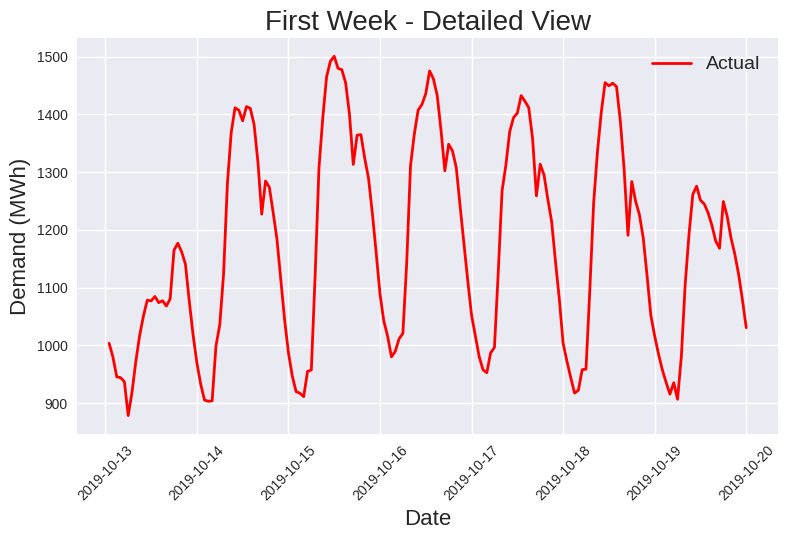

In [12]:

# Create a single figure
plt.figure()

# Select first week data
first_week_test = test.iloc[:7*24]
first_week_forecast = best_forecast.iloc[:7*24]

# Plot actual vs forecast
plt.plot(first_week_test, label='Actual', linewidth=2, color='red')
#plt.plot(first_week_test.index, first_week_forecast, label='Forecast', linewidth=2, color='green')

# Titles and labels
plt.title('First Week - Detailed View', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Demand (MWh)', fontsize=16)

# Legend, grid, and rotation
plt.legend(fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)

# Show the figure
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [13]:
# Performance by time periods
# test_df is now defined in the previous cell

print(f"\nError Analysis by Time Periods:")
print(f"Peak hours (17-20): MAE = {test_df[test_df['hour'].isin([17,18,19,20])]['abs_error'].mean():.2f}")
print(f"Off-peak hours (1-6): MAE = {test_df[test_df['hour'].isin([1,2,3,4,5,6])]['abs_error'].mean():.2f}")


# Summary table of all models
print(f"\n{'='*80}")
print(f"SUMMARY OF ALL EXPONENTIAL SMOOTHING MODELS")
print(f"{'='*80}")
print(f"{'Model':<20} {'MAPE (%)':<10} {'MAE':<10} {'RMSE':<10} {'R²':<8} {'AIC':<10}")
print("-" * 80)

for name, results in model_results.items():
    rmse_val = np.sqrt(results['mse'])
    # Ensure test data aligns with forecast for correlation calculation here as well
    test_aligned_corr = test[~test.index.duplicated(keep='first')]
    forecast_aligned_corr = results['forecast']
    if len(forecast_aligned_corr) > len(test_aligned_corr):
        forecast_aligned_corr = forecast_aligned_corr[:len(test_aligned_corr)]
    elif len(forecast_aligned_corr) < len(test_aligned_corr):
        test_aligned_corr = test_aligned_corr[:len(forecast_aligned_corr)]

    corr = np.corrcoef(test_aligned_corr, forecast_aligned_corr)[0,1]
    r2 = corr**2

    indicator = " ★" if name == best_model else ""
    print(f"{name:<20} {results['mape']:<10.2f} {results['mae']:<10.2f} {rmse_val:<10.2f} {r2:<8.4f} {results['aic']:<10.2f}{indicator}")

# Performance rating
mape_val = best_fit['mape']
if mape_val < 3:
    rating = "Excellent"
elif mape_val < 5:
    rating = "Very Good"
elif mape_val < 10:
    rating = "Good"
elif mape_val < 15:
    rating = "Fair"
else:
    rating = "Poor"

print(f"\n{'='*80}")
print(f"FINAL RESULTS - {best_model}")
print(f"{'='*80}")
print(f"Best Model: {best_model}")
print(f"Training period: {train.index.min()} to {train.index.max()}")
print(f"Test period: {test.index.min()} to {test.index.max()}")
print(f"Forecast accuracy (MAPE): {mape_val:.2f}%")
print(f"Performance Rating: {rating}")
print(f"R² Score: {r_squared:.4f}")
print(f"{'='*80}")

# Statistical tests
print(f"\nStatistical Tests:")
print(f"Residuals mean: {residuals.mean():.4f}")
print(f"Residuals std: {residuals.std():.4f}")

# Shapiro-Wilk test for normality (sample if too large)
if len(residuals) > 5000:
    sample_residuals = residuals.sample(5000, random_state=42)
else:
    sample_residuals = residuals

shapiro_stat, shapiro_p = stats.shapiro(sample_residuals)
print(f"Shapiro-Wilk Test (p-value): {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("✓ Residuals appear normally distributed")
else:
    print("✗ Residuals may not be normally distributed")

print(f"\n📊 All performance graphs have been generated!")
print(f"📈 Model ready for production use with {rating.lower()} performance.")


Error Analysis by Time Periods:
Peak hours (17-20): MAE = 108.19
Off-peak hours (1-6): MAE = 72.86

SUMMARY OF ALL EXPONENTIAL SMOOTHING MODELS
Model                MAPE (%)   MAE        RMSE       R²       AIC       
--------------------------------------------------------------------------------
Simple               13.76      180.98     240.22     0.0000   343990.96 
Double               15141.32   172116.09  198659.83  0.1086   327001.68 
Triple_Add           10.56      125.56     156.40     0.3364   277981.02 
Triple_Mul           34.38      408.23     445.06     0.3496   272265.85 
Triple_Add_Damped    9.99       120.81     148.25     0.4164   277708.98 
Triple_Mul_Damped    10.01      119.49     148.56     0.4078   272266.18  ★

FINAL RESULTS - Triple_Mul_Damped
Best Model: Triple_Mul_Damped
Training period: 2015-01-03 01:00:00 to 2019-10-13 00:00:00
Test period: 2019-10-13 01:00:00 to 2020-06-27 00:00:00
Forecast accuracy (MAPE): 10.01%
Performance Rating: Fair
R² Score: 0.407

## graphs


## Testing adding a day identifier and removing the holiday Identifier

In [14]:
# Load dataset
df = pd.read_csv("continuous dataset.csv", parse_dates=["datetime"])
df = df.set_index("datetime").sort_index()

In [15]:
df["day_of_week"] = None
df.head()



,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school,day_of_week
datetime,,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0,None
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0,None
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0,None
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0,None
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0,None


In [16]:
# Assign a number 1 to 7 in the day_of_week column (1=Sunday, 7=Saturday)
# pandas dayofweek returns Monday=0, Sunday=6. So we shift by +1 and handle Sunday (6+1=7) vs other days.
df['day_of_week'] = df.index.dayofweek + 1
df['day_of_week'] = df['day_of_week'].replace({7: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7})
df['day_of_week'] = df['day_of_week'].replace({1: 7}).replace({2:1, 3:2, 4:3, 5:4, 6:5, 7:6})


# Correct mapping: pandas Monday=0 to Sunday=6, desired Sunday=1 to Saturday=7
# Shift pandas dayofweek (0-6) to 1-7, with Sunday as 1
# pandas dayofweek: Mon=0, Tue=1, Wed=2, Thu=3, Fri=4, Sat=5, Sun=6
# Desired mapping:   Sun=1, Mon=2, Tue=3, Wed=4, Thu=5, Fri=6, Sat=7

# Step 1: Map pandas dayofweek (0-6) to temporary sequential (1-7) where Mon=1...Sun=7
df['day_of_week'] = df.index.dayofweek + 1

# Step 2: Remap to desired order (Sun=1...Sat=7)
# Current mapping is Mon=1, Tue=2,... Sat=6, Sun=7
# We want Sun=1, Mon=2,... Sat=7

# Shift everything back by 1 to get Mon=0...Sat=5, Sun=6
df['day_of_week'] = df['day_of_week'] - 1

# Now move Sun (which is 6) to position 0, and shift others
sun_mask = df['day_of_week'] == 6
df['day_of_week'][sun_mask] = 0 # Temporarily make Sunday 0
df['day_of_week'][~sun_mask] = df['day_of_week'][~sun_mask] + 1 # Shift Mon-Sat by +1

# Finally, add 1 to get the 1-7 scale with Sunday as 1
df['day_of_week'] = df['day_of_week'] + 1


display(df.head())

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school,day_of_week
datetime,,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0,7
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0,7
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0,7
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0,7
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0,7


In [21]:
# Test different Exponential Smoothing models
print("\n" + "="*60)
print("EXPONENTIAL SMOOTHING MODEL COMPARISON")
print("="*60)

models_to_test = [
    # ('Simple', None, None, None),
    # ('Double', 'add', None, None),
    # ('Triple_Add', 'add', 'add', 24),
    # ('Triple_Mul', 'mul', 'mul', 24),
    #('Triple_Add_Damped', 'add', 'add', 24)
    #,
    ('Triple_Mul_Damped', 'mul', 'mul', 24)
]

model_results = {}
best_model = None
best_aic = float('inf')

for name, trend, seasonal, seasonal_periods in models_to_test:
    try:
        print(f"\nTesting {name} Exponential Smoothing...")

        # Handle damped models
        damped_trend = 'damped' in name.lower()
        if damped_trend:
            trend = trend if trend else 'add'

        # Create model
        if name == 'Simple':
            model = ExponentialSmoothing(train, trend=None, seasonal=None)
        else:
            model = ExponentialSmoothing(
                train,
                trend=trend,
                seasonal=seasonal,
                seasonal_periods=seasonal_periods,
                damped_trend=damped_trend
            )

        # Fit model
        fitted_model = model.fit(optimized=True, use_brute=True)

        # Make forecast
        forecast = fitted_model.forecast(len(test))

        # Calculate metrics
        mse = mean_squared_error(test, forecast)
        mae = mean_absolute_error(test, forecast)
        mape = mean_absolute_percentage_error(test, forecast) * 100
        aic = fitted_model.aic if hasattr(fitted_model, 'aic') else float('inf')

        model_results[name] = {
            'model': fitted_model,
            'forecast': forecast,
            'mse': mse,
            'mae': mae,
            'mape': mape,
            'aic': aic,
            'params': fitted_model.params
        }

        print(f"  AIC: {aic:.2f}")
        print(f"  MAPE: {mape:.2f}%")
        print(f"  MAE: {mae:.2f}")

        # Track best model
        if mape < 15 and aic < best_aic:  # Only consider models with reasonable MAPE
            best_aic = aic
            best_model = name

    except Exception as e:
        print(f"  Failed: {str(e)}")
        continue



EXPONENTIAL SMOOTHING MODEL COMPARISON

Testing Triple_Mul_Damped Exponential Smoothing...
  AIC: 244246.17
  MAPE: 13.93%
  MAE: 159.36


In [22]:
# Select best model
if best_model:
    print(f"\n{'='*60}")
    print(f"BEST MODEL: {best_model} (AIC: {best_aic:.2f})")
    print(f"{'='*60}")

    best_fit = model_results[best_model]
    best_forecast = best_fit['forecast']

    # Print model parameters
    print(f"\nModel Parameters:")
    for param, value in best_fit['params'].items():
        if isinstance(value, np.ndarray):
            # Print first few elements of the array
            print(f"  {param}: {value[:5]}... (shape {value.shape})")
        elif isinstance(value, (int, float, np.floating)):
             print(f"  {param}: {value:.4f}")
        else:
            print(f"  {param}: {value}")


else:
    # Fallback to the model with best MAPE
    best_model = min(model_results.keys(), key=lambda x: model_results[x]['mape'])
    best_fit = model_results[best_model]
    best_forecast = best_fit['forecast']
    print(f"\nUsing model with best MAPE: {best_model}")


BEST MODEL: Triple_Mul_Damped (AIC: 244246.17)

Model Parameters:
  smoothing_level: 1.0000
  smoothing_trend: 0.0000
  smoothing_seasonal: 0.0000
  damping_trend: 0.9751
  initial_level: 1071.1458
  initial_trend: 1.0231
  initial_seasons: [0.90726997 0.88072039 0.86169607 0.85322349 0.86590388]... (shape (24,))
  use_boxcox: 0.0000
  lamda: None
  remove_bias: 0.0000


In [26]:

# Ensure test data aligns with forecast by removing duplicate indices
test_aligned = test[~test.index.duplicated(keep='first')]

# Make sure forecast matches test data length
if len(best_forecast) > len(test_aligned):
    best_forecast = best_forecast[:len(test_aligned)]
elif len(best_forecast) < len(test_aligned):
    test_aligned = test_aligned[:len(best_forecast)]

# Comprehensive Performance Analysis
print(f"\n{'='*60}")
print(f"DETAILED PERFORMANCE ANALYSIS - {best_model}")
print(f"{'='*60}")

# Calculate residuals
residuals = test_aligned - best_forecast
rmse = np.sqrt(best_fit['mse'])
correlation = np.corrcoef(test_aligned, best_forecast)[0,1]
r_squared = correlation**2

print(f"MSE:  {best_fit['mse']:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {best_fit['mae']:.2f}")
print(f"MAPE: {best_fit['mape']:.2f}%")
print(f"R²:   {r_squared:.4f}")
print(f"Correlation: {correlation:.4f}")


DETAILED PERFORMANCE ANALYSIS - Triple_Mul_Damped
MSE:  43356.81
RMSE: 208.22
MAE:  159.36
MAPE: 13.93%
R²:   0.5119
Correlation: 0.7154


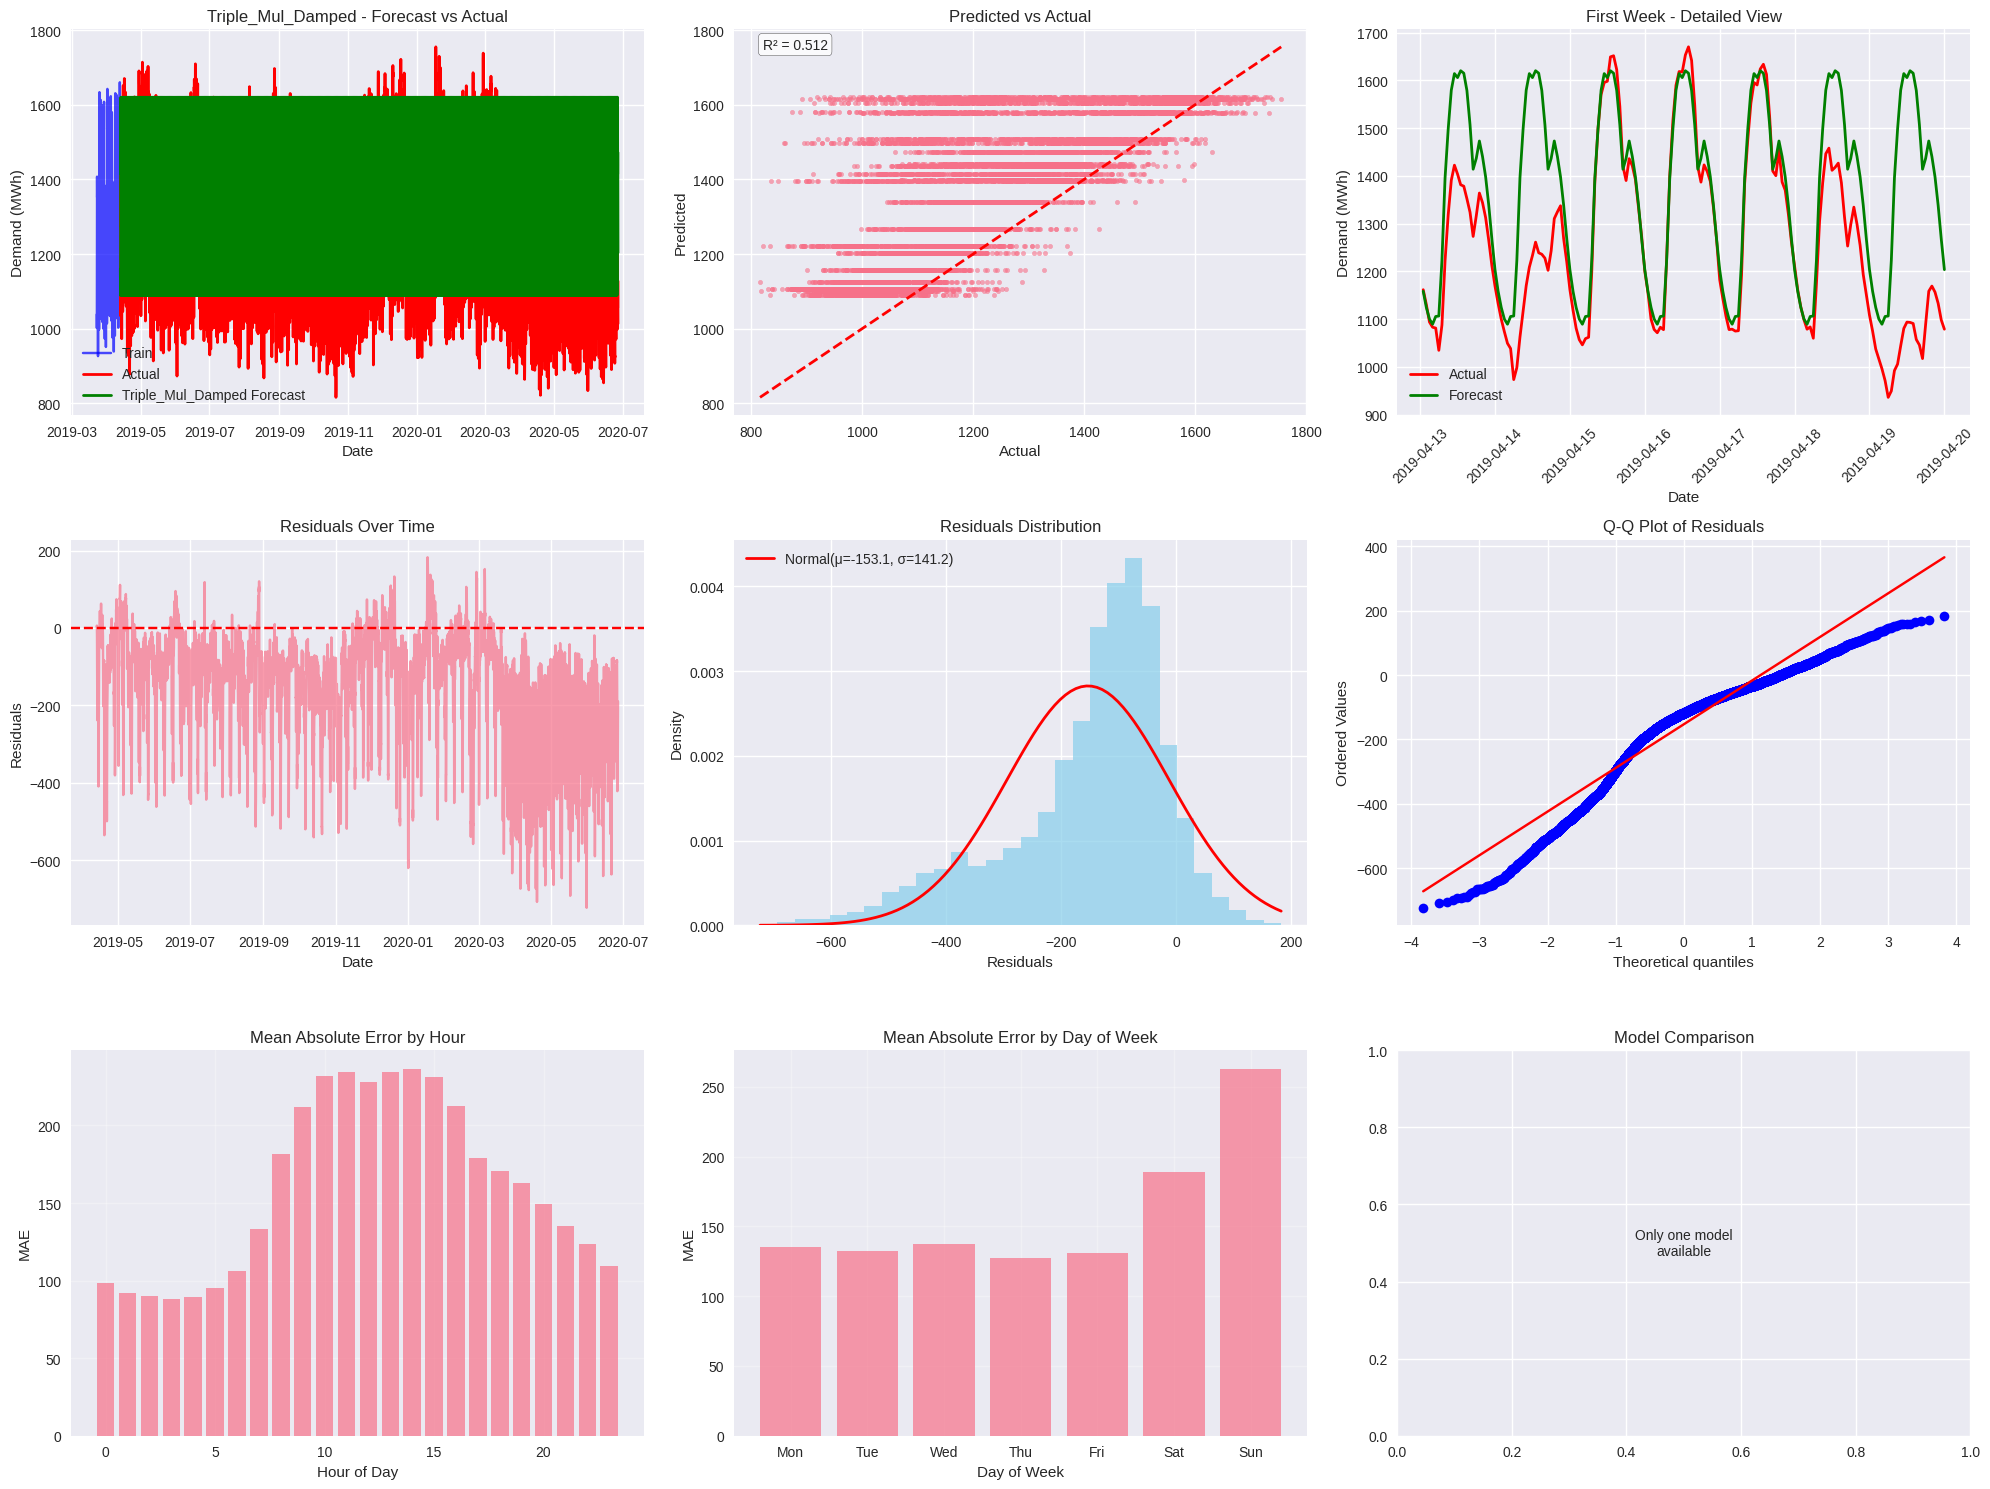

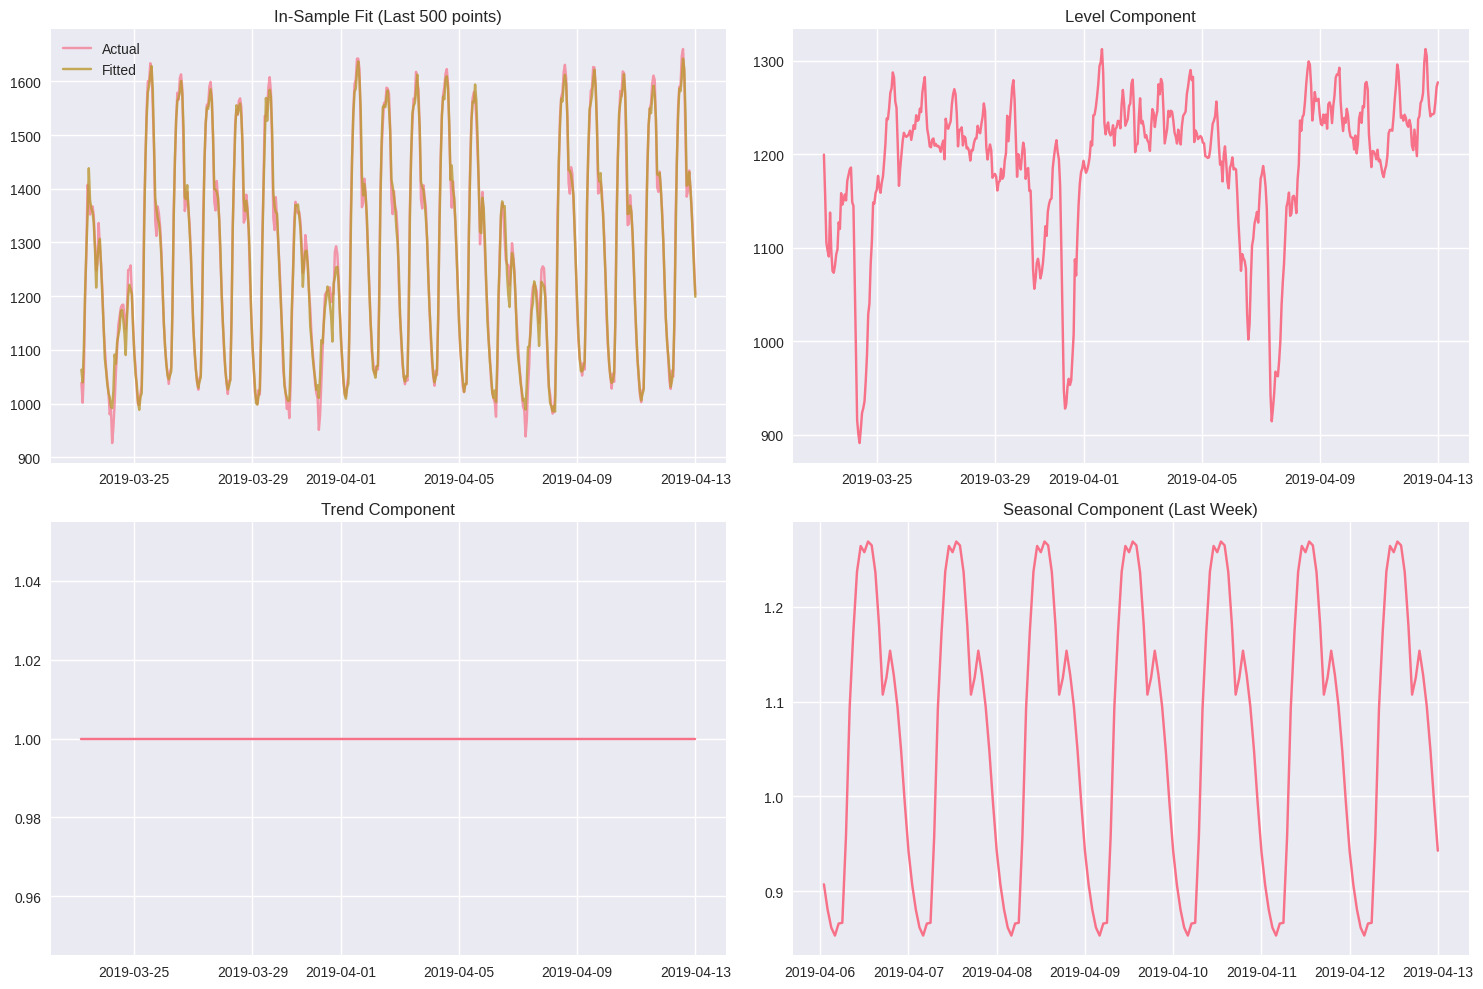

In [27]:
# Comprehensive visualization
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# Create test_df for error analysis
test_df = pd.DataFrame({
    'actual': test_aligned, # Use test_aligned for consistency with forecast alignment
    'forecast': best_forecast,
    'error': residuals,
    'abs_error': np.abs(residuals),
    'pct_error': (residuals / test_aligned) * 100 # Use test_aligned here too
})

test_df['hour'] = test_df.index.hour
test_df['day_of_week'] = test_df.index.day_of_week


# 1. Forecast vs Actual (overview)
axes[0,0].plot(train[-500:], label="Train", alpha=0.7, color='blue')
axes[0,0].plot(test, label="Actual", color='red', linewidth=2)
axes[0,0].plot(test.index, best_forecast, label=f"{best_model} Forecast", color='green', linewidth=2)
axes[0,0].set_title(f"{best_model} - Forecast vs Actual")
axes[0,0].set_xlabel("Date")
axes[0,0].set_ylabel("Demand (MWh)")
axes[0,0].legend()
axes[0,0].grid(True)

# 2. Predicted vs Actual scatter plot
axes[0,1].scatter(test, best_forecast, alpha=0.6, s=10)
axes[0,1].plot([test.min(), test.max()], [test.min(), test.max()], 'r--', lw=2)
axes[0,1].set_xlabel('Actual')
axes[0,1].set_ylabel('Predicted')
axes[0,1].set_title('Predicted vs Actual')
axes[0,1].grid(True)
axes[0,1].text(0.05, 0.95, f'R² = {r_squared:.3f}', transform=axes[0,1].transAxes,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. First week detailed view
first_week_test = test.iloc[:7*24]
first_week_forecast = best_forecast.iloc[:7*24]
axes[0,2].plot(first_week_test, label='Actual', linewidth=2, color='red')
axes[0,2].plot(first_week_test.index, first_week_forecast, label='Forecast', linewidth=2, color='green')
axes[0,2].set_title('First Week - Detailed View')
axes[0,2].set_xlabel('Date')
axes[0,2].set_ylabel('Demand (MWh)')
axes[0,2].legend()
axes[0,2].grid(True)
axes[0,2].tick_params(axis='x', rotation=45)

# 4. Residuals over time
axes[1,0].plot(test.index, residuals, alpha=0.7)
axes[1,0].axhline(y=0, color='r', linestyle='--')
axes[1,0].set_title('Residuals Over Time')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Residuals')
axes[1,0].grid(True)

# 5. Residuals distribution
axes[1,1].hist(residuals, bins=30, alpha=0.7, density=True, color='skyblue')
axes[1,1].set_title('Residuals Distribution')
axes[1,1].set_xlabel('Residuals')
axes[1,1].set_ylabel('Density')

# Overlay normal distribution
mu, sigma = stats.norm.fit(residuals)
x = np.linspace(residuals.min(), residuals.max(), 100)
axes[1,1].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label=f'Normal(μ={mu:.1f}, σ={sigma:.1f})')
axes[1,1].legend()
axes[1,1].grid(True)

# 6. Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1,2])
axes[1,2].set_title('Q-Q Plot of Residuals')
axes[1,2].grid(True)

# 7. Error by hour of day
hourly_error = test_df.groupby('hour')['abs_error'].mean()
axes[2,0].bar(hourly_error.index, hourly_error.values, alpha=0.7)
axes[2,0].set_title('Mean Absolute Error by Hour')
axes[2,0].set_xlabel('Hour of Day')
axes[2,0].set_ylabel('MAE')
axes[2,0].grid(True, alpha=0.3)

# 8. Error by day of week
daily_error = test_df.groupby('day_of_week')['abs_error'].mean()
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[2,1].bar(range(7), daily_error.values, alpha=0.7)
axes[2,1].set_title('Mean Absolute Error by Day of Week')
axes[2,1].set_xlabel('Day of Week')
axes[2,1].set_ylabel('MAE')
axes[2,1].set_xticks(range(7))
axes[2,1].set_xticklabels(day_names)
axes[2,1].grid(True, alpha=0.3)

# 9. Model comparison
if len(model_results) > 1:
    model_names = list(model_results.keys())
    mapes = [model_results[name]['mape'] for name in model_names]

    bars = axes[2,2].bar(range(len(model_names)), mapes, alpha=0.7)
    axes[2,2].set_title('Model Comparison (MAPE)')
    axes[2,2].set_xlabel('Model')
    axes[2,2].set_ylabel('MAPE (%)')
    axes[2,2].set_xticks(range(len(model_names)))
    axes[2,2].set_xticklabels(model_names, rotation=45)
    axes[2,2].grid(True, alpha=0.3)

    # Highlight best model
    best_idx = model_names.index(best_model)
    bars[best_idx].set_color('gold')
else:
    axes[2,2].text(0.5, 0.5, 'Only one model\navailable', ha='center', va='center', transform=axes[2,2].transAxes)
    axes[2,2].set_title('Model Comparison')

plt.tight_layout()
plt.show()

# Model components visualization (if available)
if hasattr(model_results[best_model]['model'], 'level'):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Get fitted values and components
    fitted_values = model_results[best_model]['model'].fittedvalues

    # In-sample fit
    axes[0,0].plot(train[-500:], label='Actual', alpha=0.7)
    axes[0,0].plot(fitted_values[-500:], label='Fitted', alpha=0.8)
    axes[0,0].set_title('In-Sample Fit (Last 500 points)')
    axes[0,0].legend()
    axes[0,0].grid(True)

    # Level component
    if hasattr(model_results[best_model]['model'], 'level'):
        axes[0,1].plot(model_results[best_model]['model'].level[-500:])
        axes[0,1].set_title('Level Component')
        axes[0,1].grid(True)

    # Trend component (if exists)
    if hasattr(model_results[best_model]['model'], 'trend'):
        axes[1,0].plot(model_results[best_model]['model'].trend[-500:])
        axes[1,0].set_title('Trend Component')
        axes[1,0].grid(True)

    # Seasonal component (if exists)
    if hasattr(model_results[best_model]['model'], 'season'):
        seasonal_comp = model_results[best_model]['model'].season
        if seasonal_comp is not None:
            axes[1,1].plot(seasonal_comp[-168:])  # Last week
            axes[1,1].set_title('Seasonal Component (Last Week)')
            axes[1,1].grid(True)

    plt.tight_layout()
    plt.show()